In [56]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import urllib.request
import os

import matplotlib.pyplot as plt

# YOU HAVE FORGOTTEN TO ONLY DO STATEBASE!!!!!

In [57]:
def get_gwno():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO'#local
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno

def get_prio_shape():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO'#local
    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    return prio_grid


def get_gwno():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO' #local
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno


def get_ucdp():

    #location = '/home/projects/ku_00017/data/raw/UCDP'
    location = '/home/simon/Documents/Bodies/data/UCDP' #local
    path_ucdp = location + "/ged201-csv.zip"
    
    if os.path.isfile(path_ucdp) == True:
        print('file already downloaded')
        ucdp = pd.read_csv(path_ucdp, low_memory=False)


    else: 
        print('Beginning file download UCDP...')

        url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    
        urllib.request.urlretrieve(url_ucdp, path_ucdp)
        ucdp = pd.read_csv(path_ucdp, low_memory=False)


    # just to save ram for now !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    sub_years = sorted(ucdp['year'].unique())[:4]
    ucdp = ucdp[ucdp['year'].isin(sub_years)]
    # -----------------------------------------------------------------------------------------------------

    ucdp['month'] = pd.to_datetime(ucdp['date_start']).dt.month
    ucdp.rename(columns= {'priogrid_gid' : 'gid'}, inplace= True)

    ucdp = ucdp[ucdp['type_of_violence'] == 2].copy()

    feature_list = ['month','year', 'gid', 'deaths_a','deaths_b', 'deaths_civilians', 'deaths_unknown','best', 'high', 'low']

    ucdp_monthly_unit = ucdp.loc[:,feature_list].groupby(['month','year', 'gid']).sum().reset_index()
    ucdp_monthly_unit['log_best'] = np.log(ucdp_monthly_unit['best'] +1)
    ucdp_monthly_unit['log_low'] = np.log(ucdp_monthly_unit['low'] +1)
    ucdp_monthly_unit['log_high'] = np.log(ucdp_monthly_unit['high'] +1)

    ucdp_monthly_unit['in_ucdp'] = True # handy later when I wnat to remove water and stuff.

    return ucdp_monthly_unit


In [58]:
def get_views_data():

    path_views = '/home/simon/Documents/Articles/ConflictNet/data/raw/ucdp_views_priogrid_month.csv.zip'
    #path_views = '/home/projects/ku_00017/data/raw/......./ucdp_views_priogrid_month.csv.zip'

    if os.path.isfile(path_views) == True:

        df_views = pd.read_csv(path_views)

    else: 
        print('Beginning file download ViEWS...')
        
        url_views = 'https://views.pcr.uu.se/download/datasets/ucdp_views_priogrid_month.csv.zip'
        urllib.request.urlretrieve(url_views, path_views)
        df_views = pd.read_csv(path_views)

    return df_views


In [59]:
def monthly_grid(prio_grid, ucdp):

    years = [sorted(ucdp['year'].unique())] * prio_grid.shape[0]
    months = [list(np.arange(1, 13))] * prio_grid.shape[0]

    prio_grid['year'] = years
    prio_grid['month'] = months

    prio_grid = prio_grid.explode('year').reset_index(drop=True) 
    prio_grid = prio_grid.explode('month').reset_index(drop=True) 

    prio_grid['year'] = prio_grid['year'].astype(int)
    prio_grid['month'] = prio_grid['month'].astype(int)

    return prio_grid

In [60]:

def make_full_grid(prio_grid, ucdp, gwno):

    prio_grid = prio_grid.merge(gwno, on = ['gid', 'year'], how = 'left') 

    # you can easily add monthly prio features here (if you got the ram for it)

    full_grid = prio_grid.merge(ucdp, on = ['gid', 'year', 'month'], how = 'left') 
    full_grid.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0, 'gwno' : 0}, inplace = True) # for gwno 0 is no country
    full_grid.fillna({'in_ucdp' : False}, inplace = True)

    full_grid['log_best'] = np.log(full_grid['best'] + 1)
    full_grid['log_high'] = np.log(full_grid['high'] + 1)
    full_grid['log_low'] = np.log(full_grid['low'] + 1)

    return full_grid

In [61]:
def add_month_id(prio_grid):

    prio_grid['year_month'] = prio_grid['year'].astype(str) + '_' + prio_grid['month'].astype(str) 

    ts = prio_grid['year_month'].unique()
    n_ts = len(ts)
    month_ids = np.arange(109, n_ts + 109, 1)
    month_id_df = pd.DataFrame({'year_month' : ts, 'month_id': month_ids})
    prio_grid = prio_grid.merge(month_id_df, on = 'year_month', how = 'left')

    return prio_grid

In [62]:
def check_month_id(prio_grid):

    for year in prio_grid['year'].unique():
        print(year, end = ': ')
        print(prio_grid[prio_grid['year'] == year]['month_id'].unique(), end = ': ')
        print(len(prio_grid[prio_grid['year'] == year]['month_id'].unique()))

In [63]:
def get_views_sub(prio_grid, df_views):

    africa_gids = df_views['pg_id'].unique()
    #views_months = df_views['month_id'].unique()

    #Last month in test is dec 2017
    views_month_last = df_views[(df_views['year'] == 2017) & (df_views['month'] == 12)]['month_id'].unique().item()


    max_coords = prio_grid[prio_grid['gid'].isin(africa_gids)][['xcoord', 'ycoord']].max() + (1,3.25) # get both dim to 180
    min_coords = prio_grid[prio_grid['gid'].isin(africa_gids)][['xcoord', 'ycoord']].min() - (1,3)
    mask1 = ((prio_grid['xcoord'] < max_coords[0]) & (prio_grid['xcoord'] > min_coords[0]) & (prio_grid['ycoord'] < max_coords[1]) & (prio_grid['ycoord'] > min_coords[1]) & (prio_grid['month_id'] <= views_month_last))
    views_subset = prio_grid[mask1].copy()
    col_to_change = views_subset.columns[7:18]
    views_subset.loc[~views_subset['gid'].isin(africa_gids), col_to_change] = 0
    views_subset.reset_index(inplace=True, drop = True)

    world_subset = prio_grid[prio_grid['month_id'] <= views_month_last].copy()

    return views_subset, world_subset

In [64]:
def make_volumn(df):

    # we start with wat we know - but there is no reason not to try with more down til line.

    sub_df = df[['gid', 'xcoord', 'ycoord', 'month_id', 'best', 'low', 'high', 'log_best', 'log_low', 'log_high', 'gwno']].copy() # remove the everything also the geo col.

    sub_df_sorted = sub_df.sort_values(['month_id', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = sub_df['xcoord'].unique().shape[0]
    y_dim = sub_df['ycoord'].unique().shape[0]
    z_dim = sub_df['month_id'].unique().shape[0]

    ucpd_vol = np.array(sub_df_sorted).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol

In [65]:
prio_grid = get_prio_shape()
gwno = get_gwno()
ucdp = get_ucdp()

File already downloaded
file already downloaded


In [66]:
prio_grid = monthly_grid(prio_grid, ucdp)
prio_grid = make_full_grid(prio_grid, ucdp, gwno)
prio_grid = add_month_id(prio_grid)
print(prio_grid.shape)

In [ ]:
df_views = get_views_data()
views_subset, world_subset = get_views_sub(prio_grid, df_views)

In [ ]:
world_subset['month_id'].unique() == views_subset['month_id'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [ ]:
ucdp

In [55]:
ucdp

,month,year,gid,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,type_of_violence,log_best,log_low,log_high,in_ucdp
0,1,1989,86102,0,1,0,0,1,1,1,2,0.693147,0.693147,0.693147,True
1,1,1989,86821,2,1,2,4,9,10,9,21,2.302585,2.302585,2.397895,True
2,1,1989,86822,6,1,2,1,10,10,10,21,2.397895,2.397895,2.397895,True
3,1,1989,86823,1,0,1,0,2,2,2,4,1.098612,1.098612,1.098612,True
4,1,1989,87542,0,1,0,0,1,1,1,2,0.693147,0.693147,0.693147,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6628,12,1992,194076,0,0,4,0,4,4,4,1,1.609438,1.609438,1.609438,True
6629,12,1992,194077,2,0,0,0,2,2,2,1,1.098612,1.098612,1.098612,True
6630,12,1992,194078,0,0,5,3,8,8,8,1,2.197225,2.197225,2.197225,True
6631,12,1992,208429,1,0,0,0,1,1,1,1,0.693147,0.693147,0.693147,True


In [14]:
views_vol = make_volumn(views_subset)
print(views_vol.shape)

(48, 180, 180, 11)


In [15]:
worlds_vol = make_volumn(world_subset)
print(worlds_vol.shape)

(48, 360, 720, 11)


In [16]:
# check_month_id(prio_grid)
# check_month_id(df_views)

But this does not fly as destroy the square format.
the easy solotion: 
- Set all non african log_best (ect) to 0. 
- Drop all observationnot within some reasnoble square around africa.

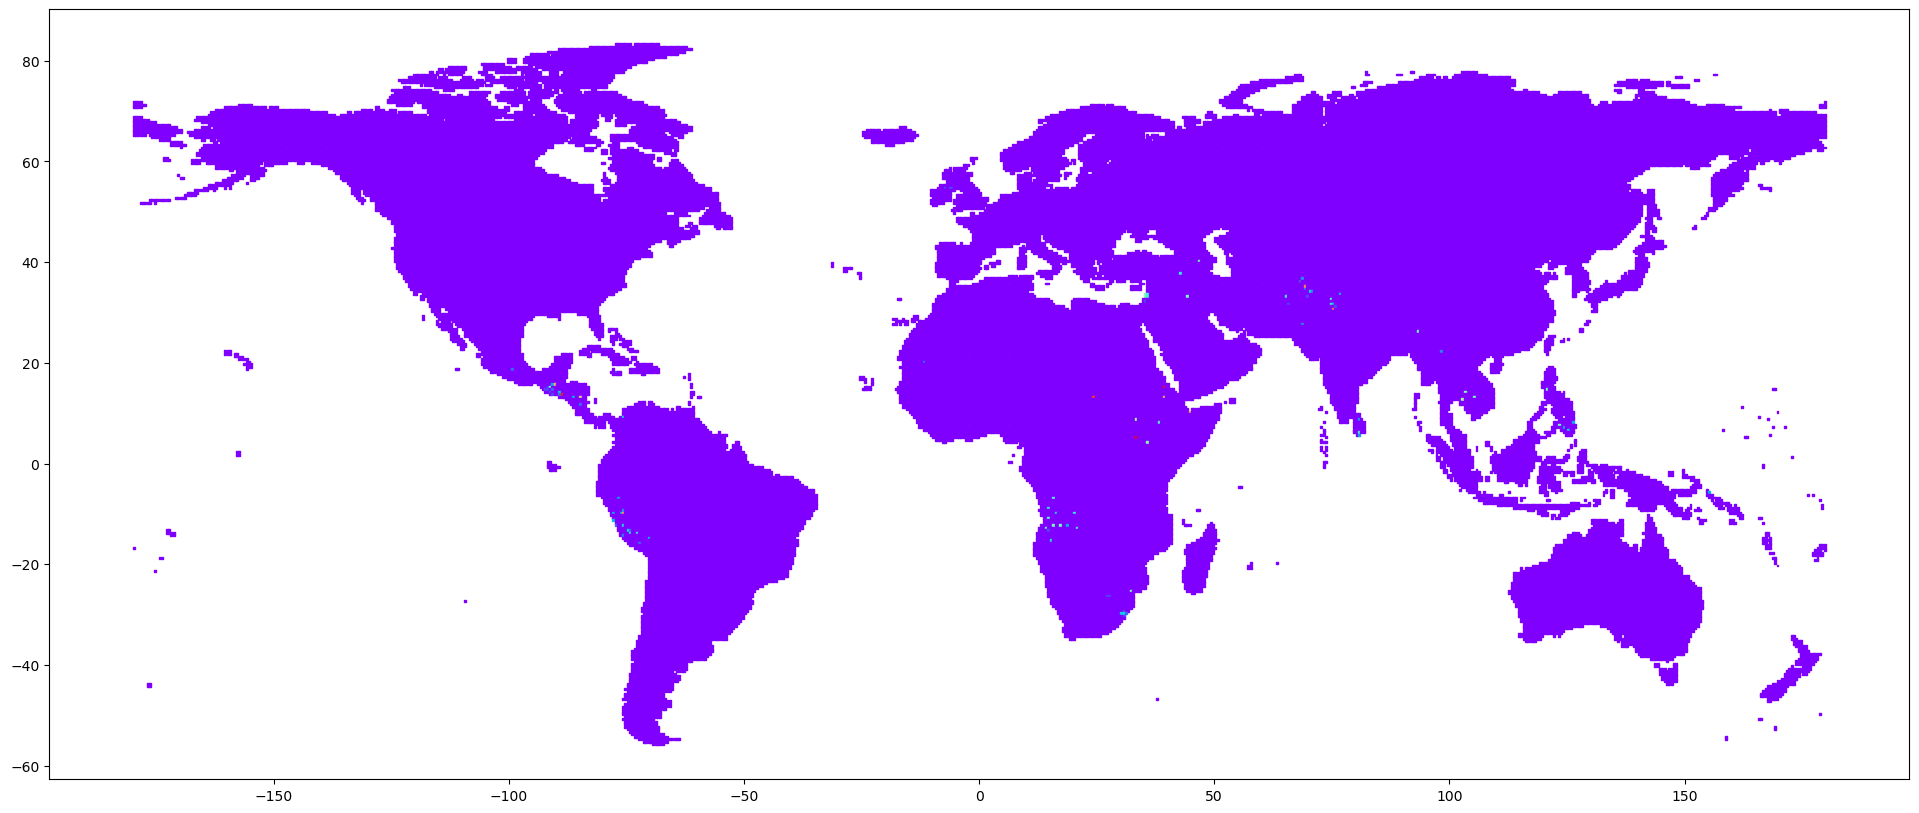

In [17]:
plt.figure(figsize= [24,10])

sub_df = world_subset[(world_subset['month_id'] == 109) & (world_subset['gwno'] > 0)] # you nee to do sometion about all the not here gid cells?

x = sub_df['xcoord']
y = sub_df['ycoord']
z =sub_df['log_best']

plt.scatter(x, y, c=z, s=2, marker = 's', cmap = 'rainbow')
plt.show()

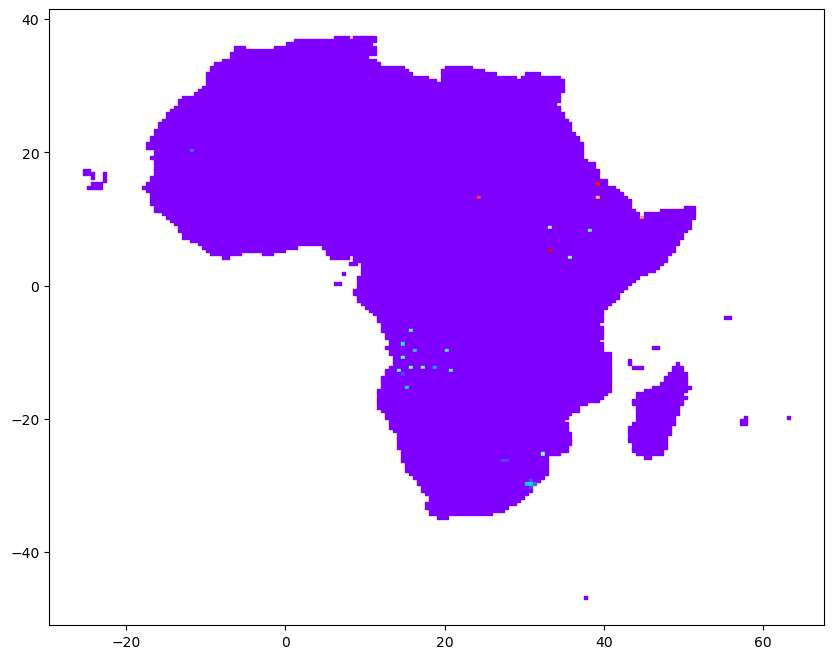

In [18]:
plt.figure(figsize= [10,8])

sub_df = views_subset[(views_subset['month_id'] == 109) & (views_subset['gwno'] > 0)] # you nee to do sometion about all the not here gid cells?

x = sub_df['xcoord']
y = sub_df['ycoord']
z =sub_df['log_best']

plt.scatter(x, y, c=z, s=5, marker = 's', cmap = 'rainbow')
plt.show()

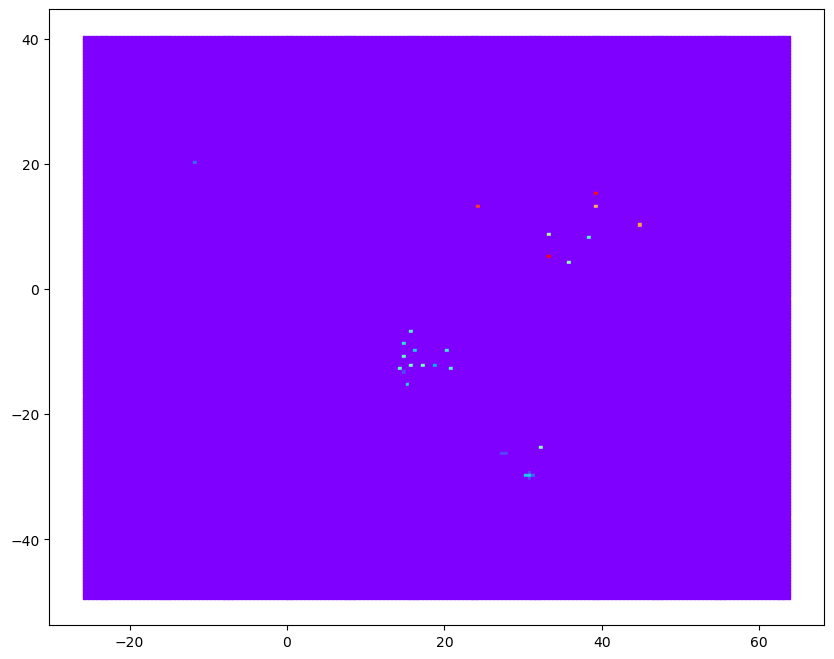

In [19]:
plt.figure(figsize= [10,8])

sub_df = views_subset[(views_subset['month_id'] == 109)] # you nee to do sometion about all the not here gid cells?

x = sub_df['xcoord']
y = sub_df['ycoord']
z =sub_df['log_best']

plt.scatter(x, y, c=z, s=5, marker = 's', cmap = 'rainbow')
plt.show()

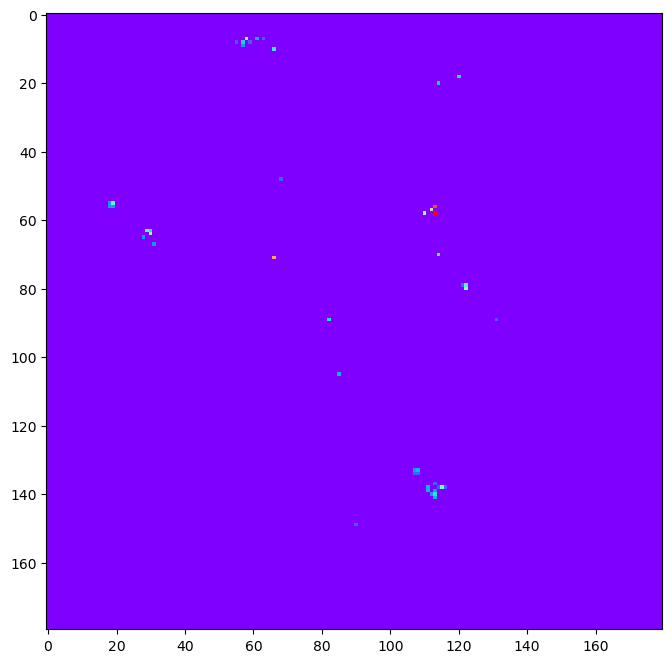

In [20]:
plt.figure(figsize= [20,8])
plt.imshow(views_vol[-1,:,:,7], cmap = 'rainbow', vmin=views_vol[-1,:,:,7].min() , vmax=views_vol[-1,:,:,7].max())
plt.show()

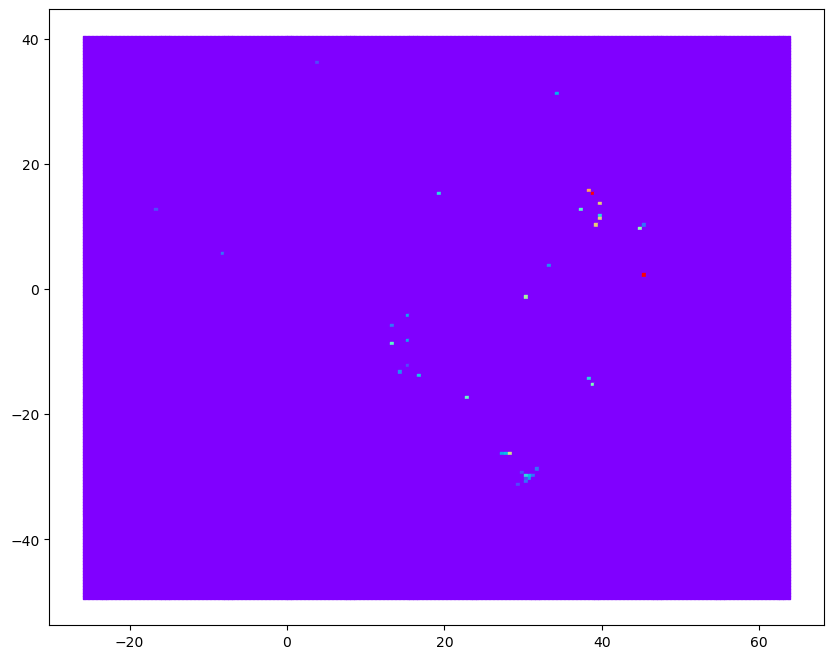

In [21]:
#mask = (prio_grid['month_id'] == 132) & (prio_grid['gwno'] != 0)
mask = views_subset['month_id'] == 132

sub_grid = views_subset[mask]

x = sub_grid['xcoord']
y = sub_grid['ycoord']
z = sub_grid['log_best']

plt.figure(figsize= [10,8])
plt.scatter(x, y, c = z, marker= 's', s = 5, cmap = 'rainbow', vmin=z.min(), vmax=z.max() )
plt.show()

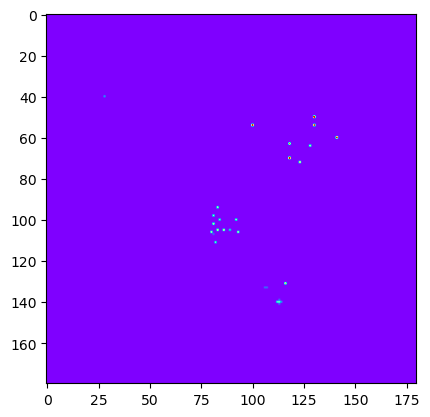

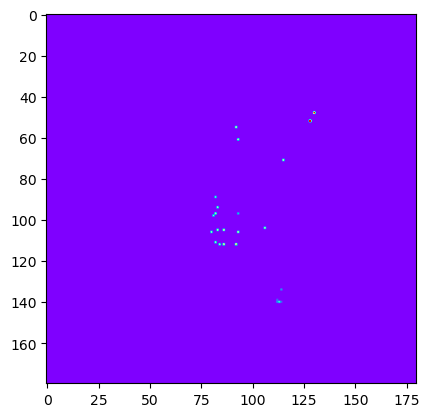

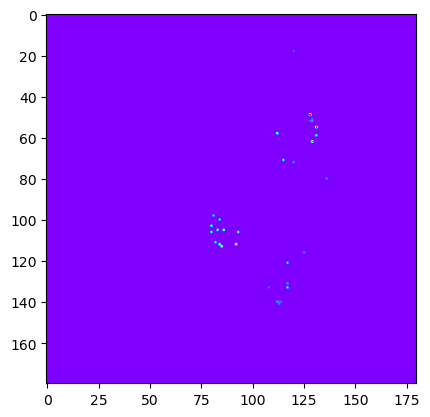

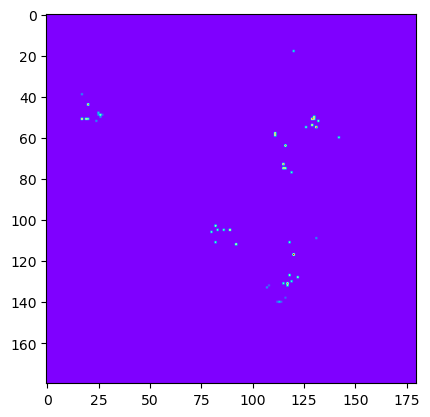

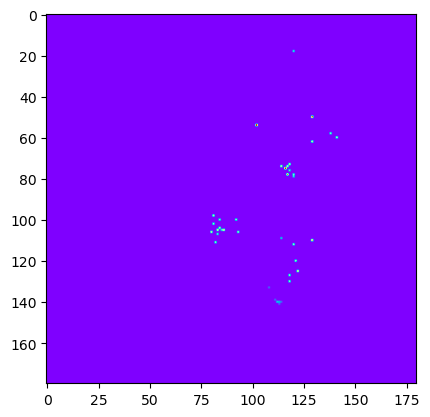

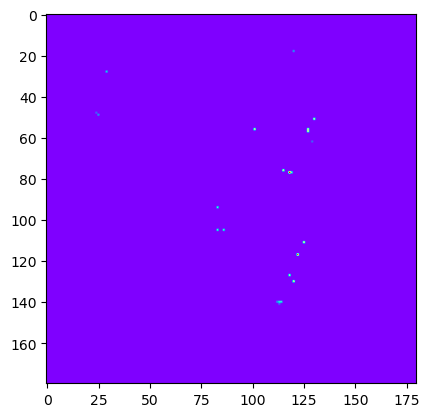

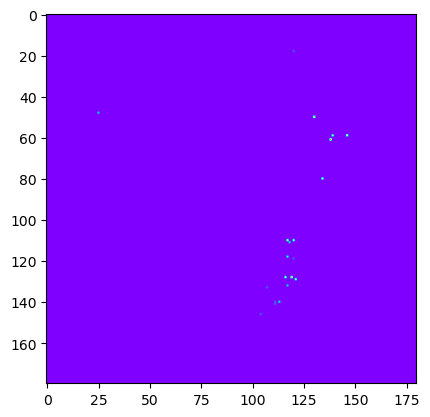

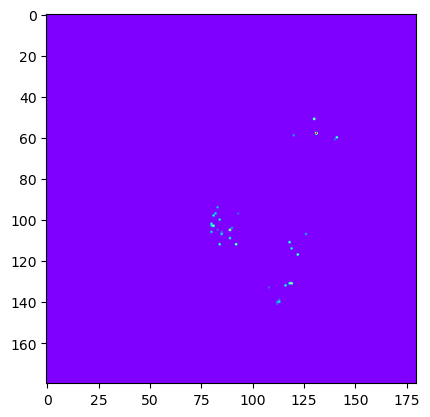

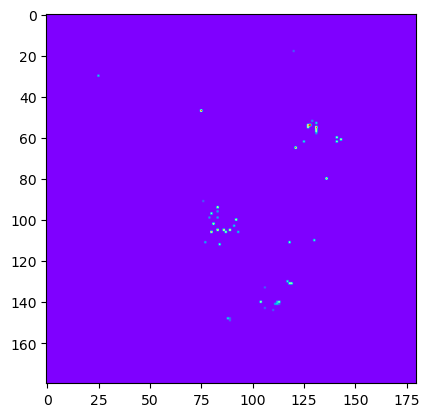

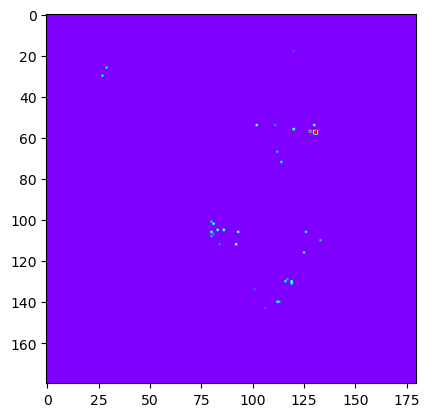

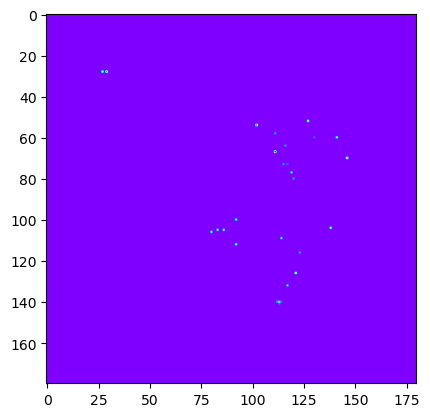

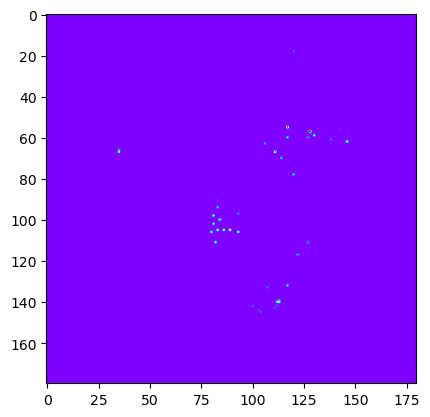

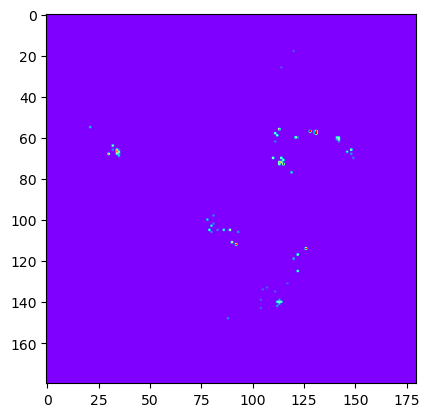

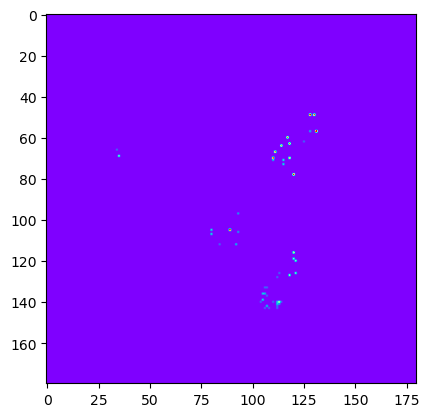

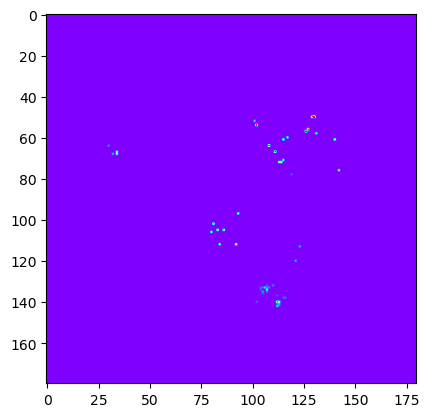

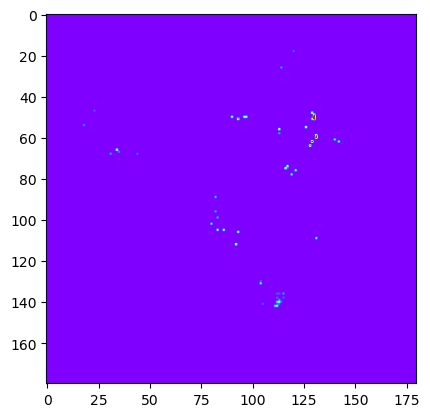

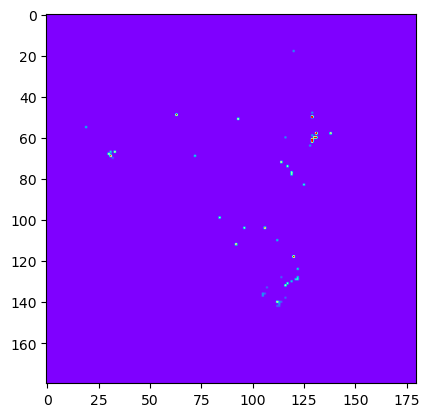

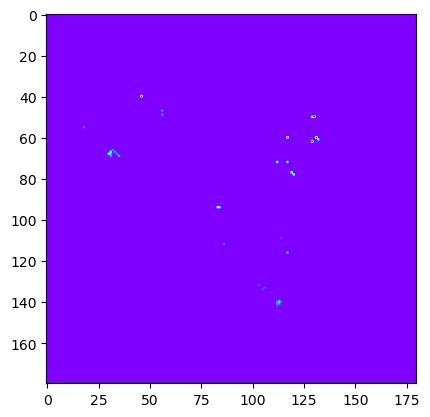

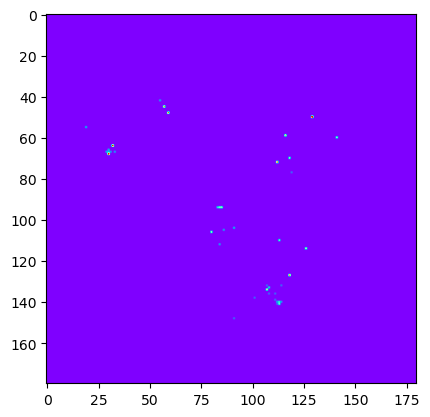

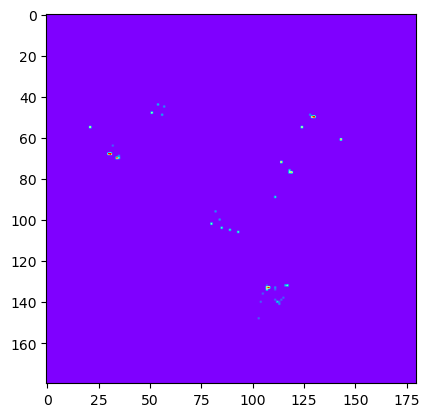

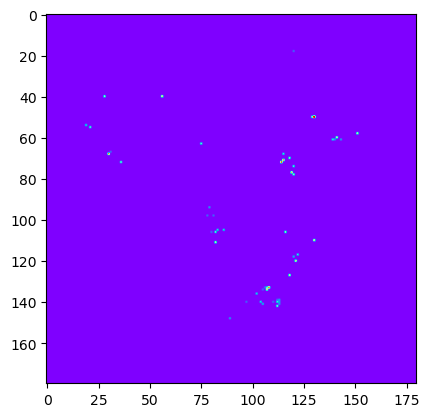

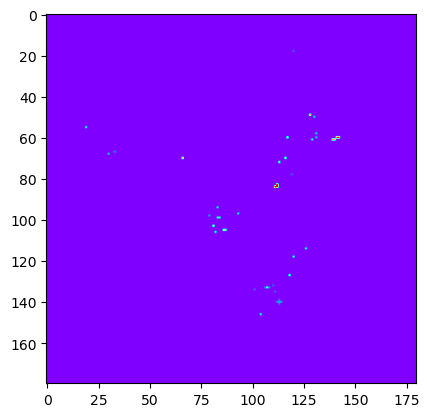

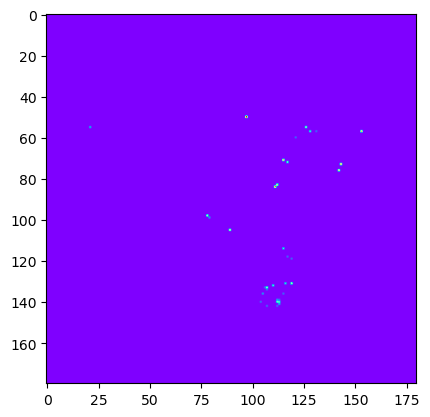

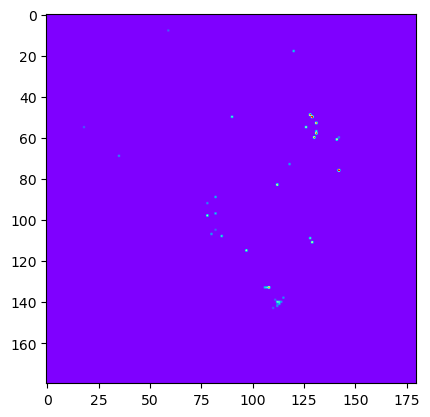

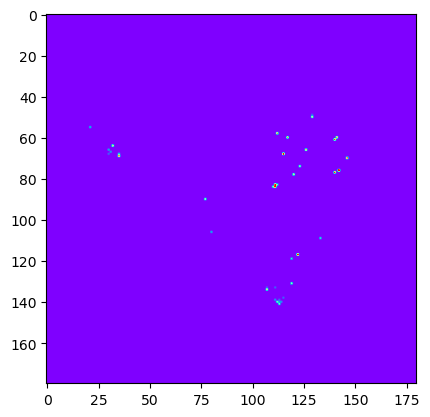

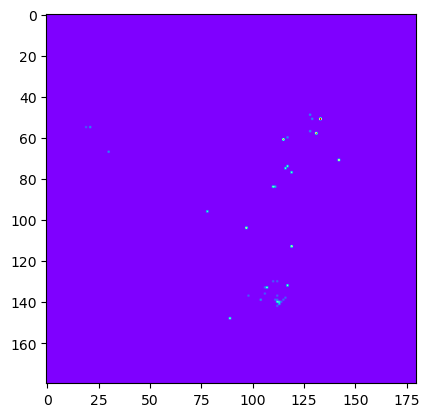

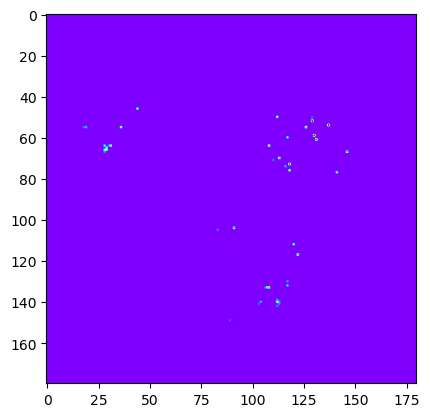

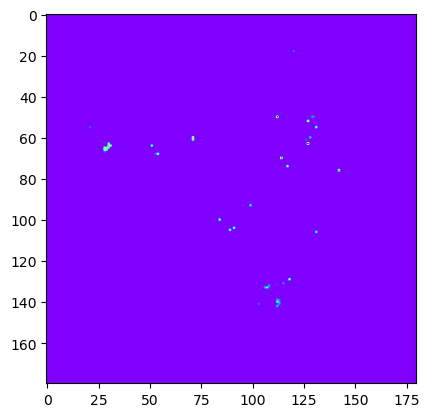

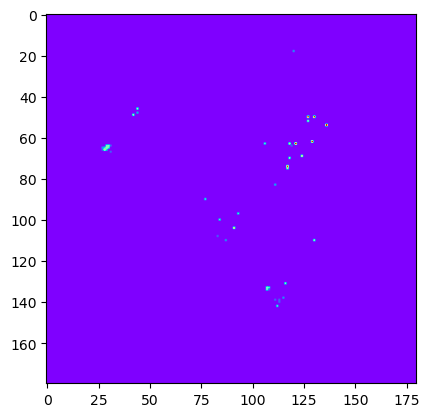

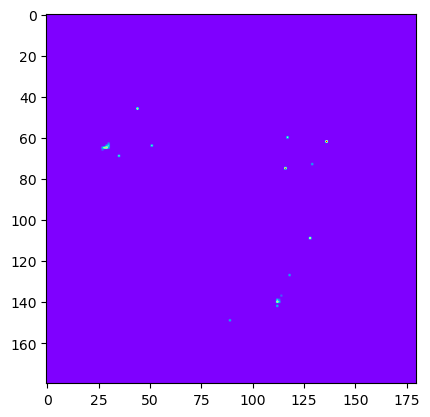

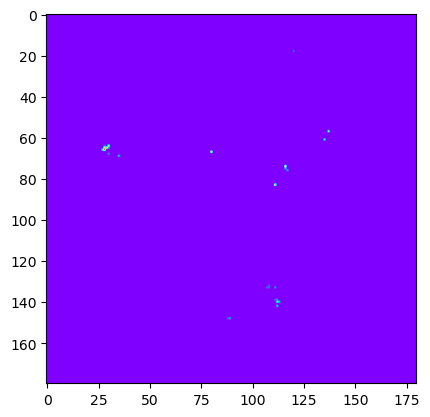

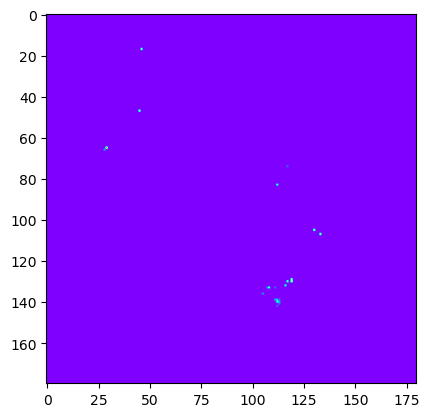

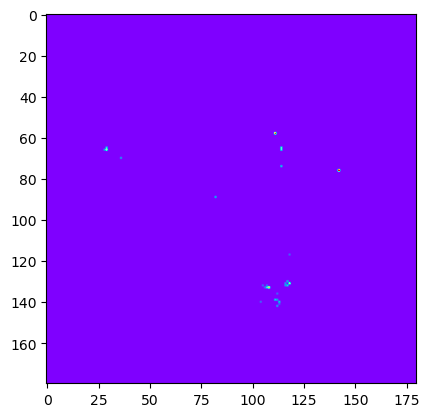

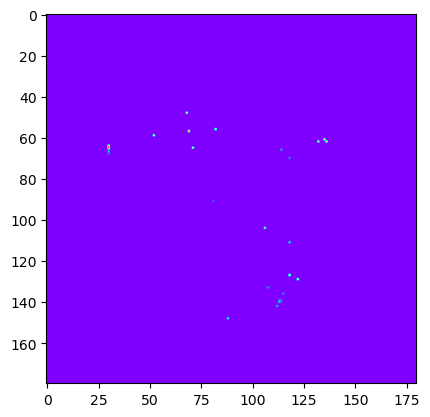

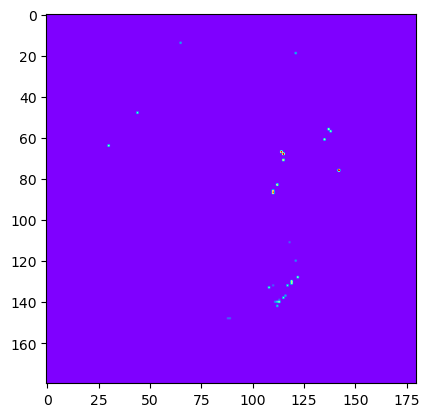

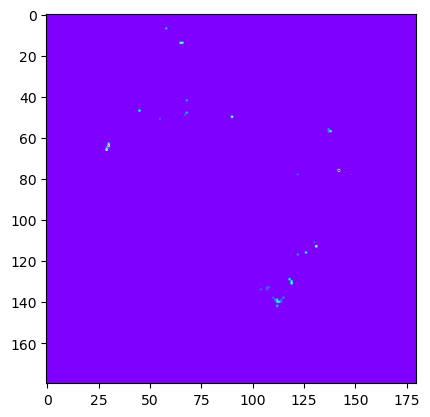

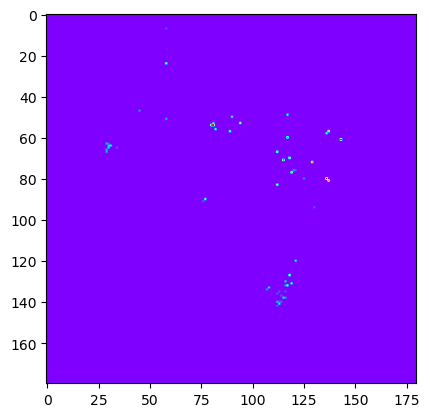

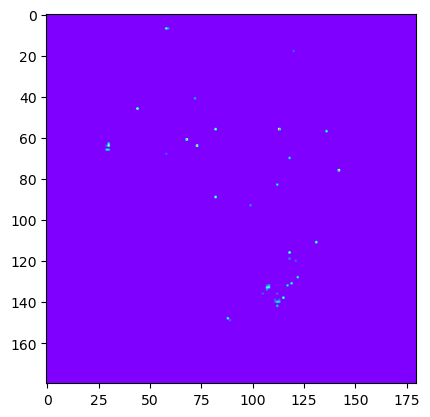

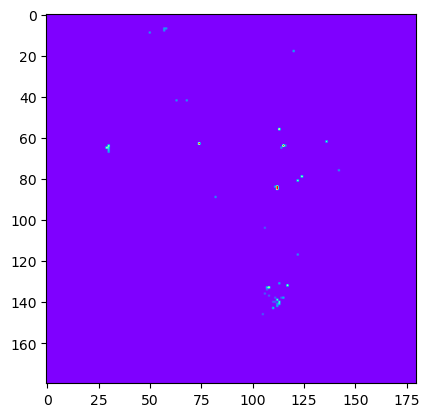

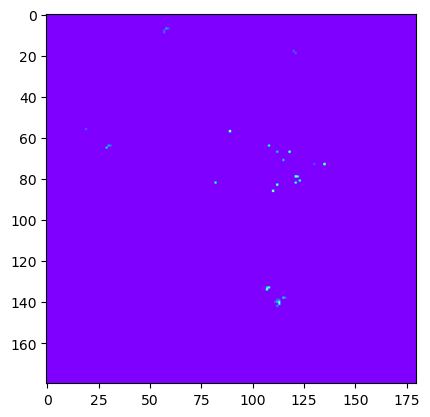

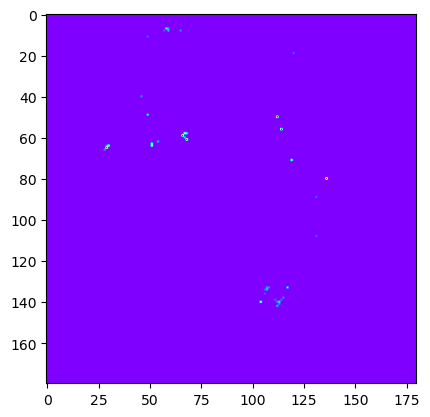

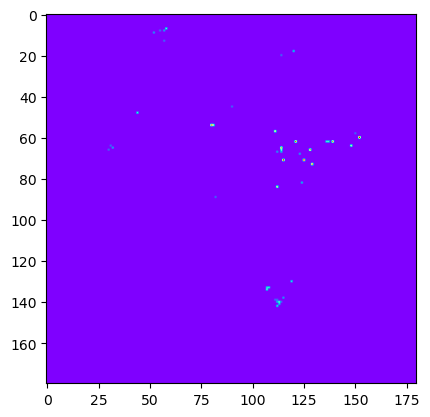

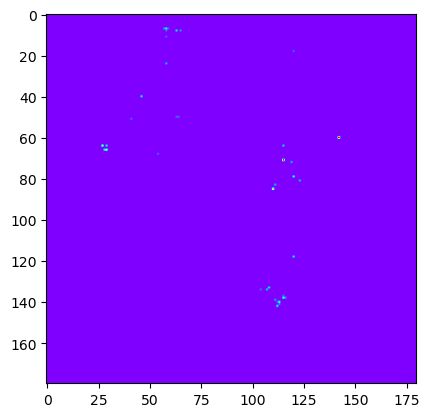

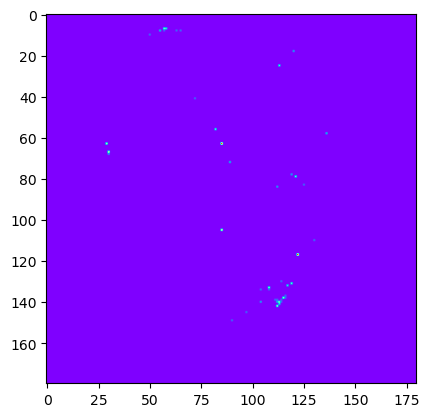

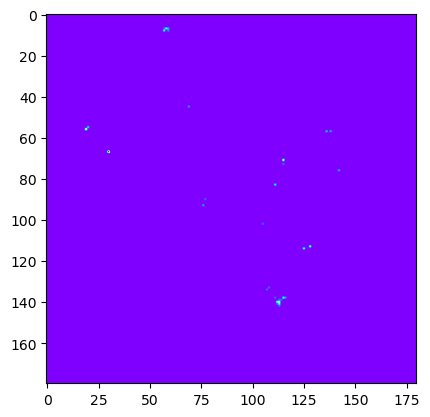

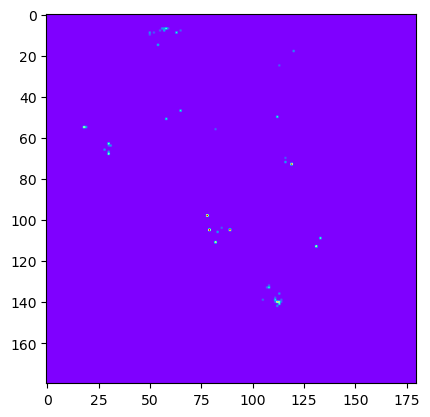

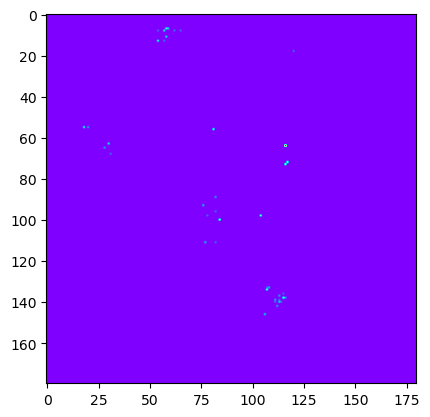

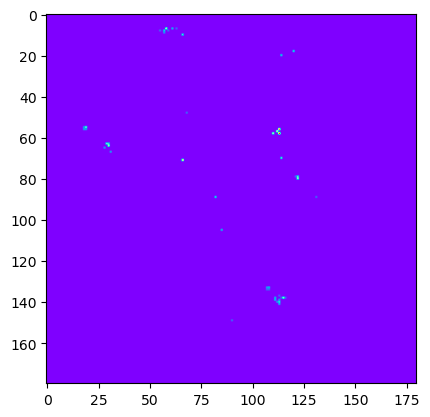

In [22]:
for i in range(views_vol.shape[0]):

    #plt.figure(figsize= [20,8])
    plt.imshow(views_vol[i,:,:,7], cmap = 'rainbow', vmin=views_vol[-1,:,:,7].min() , vmax=views_vol[-1,:,:,7].max())
    plt.show()

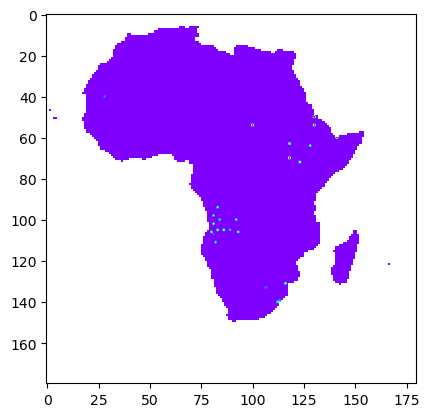

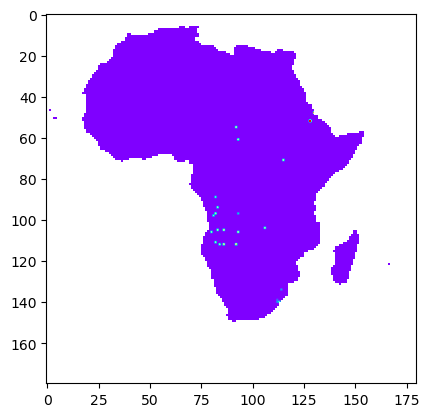

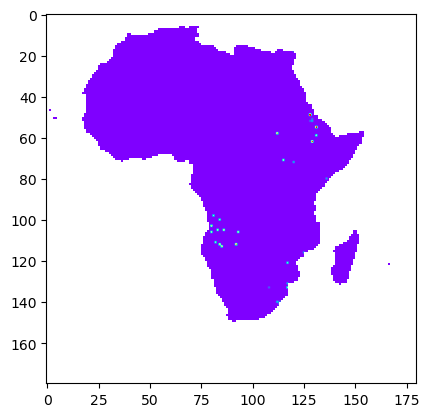

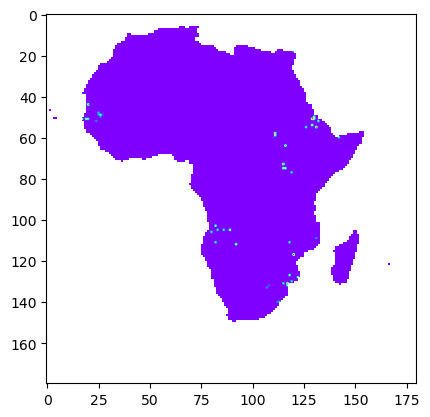

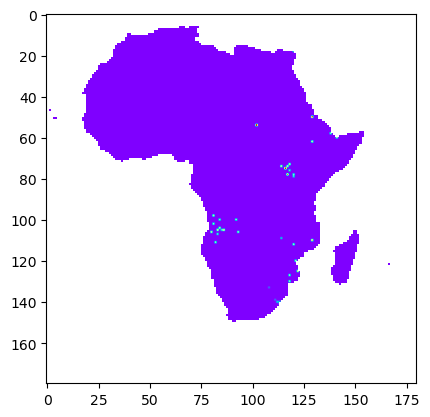

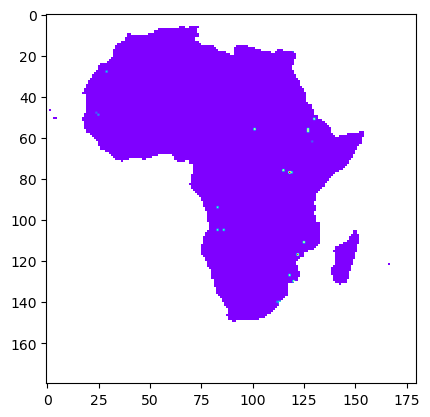

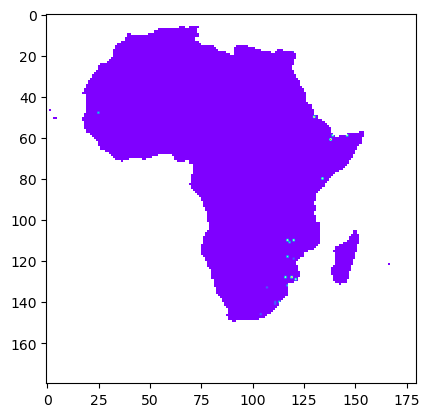

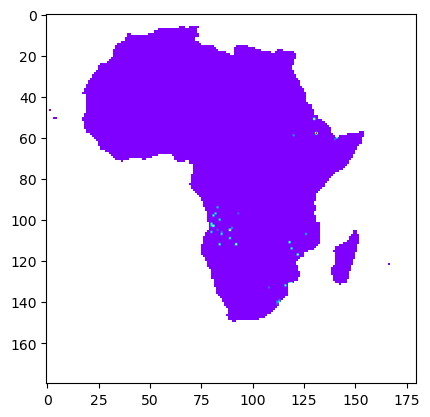

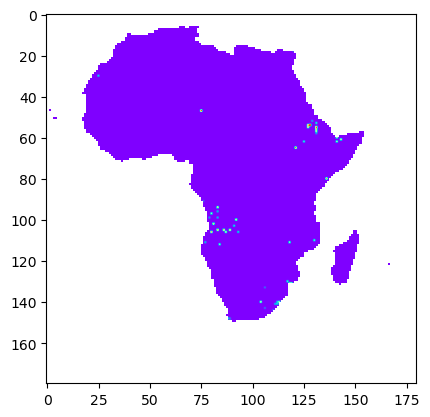

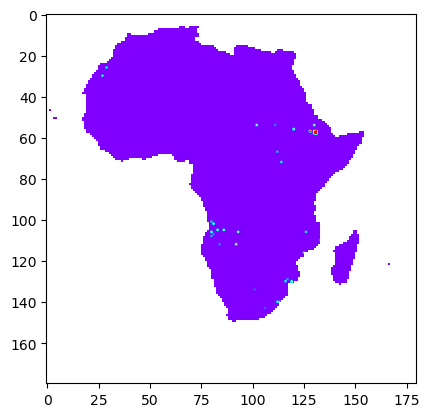

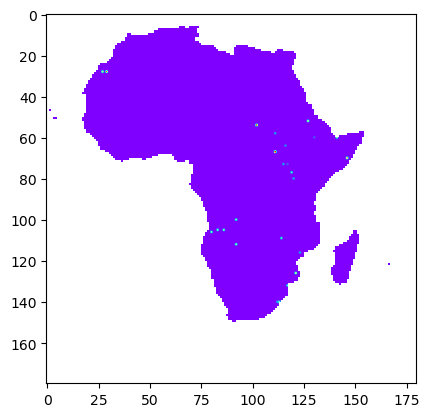

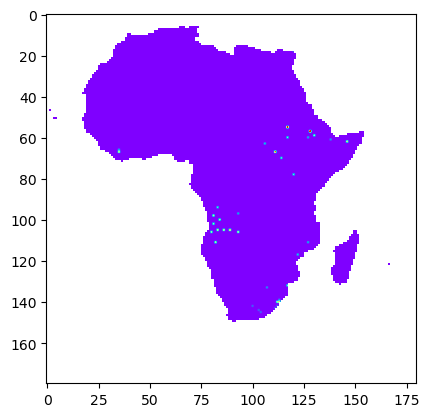

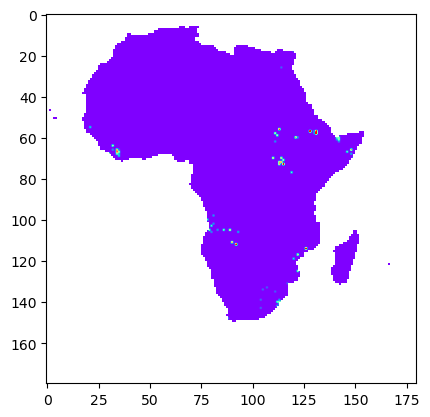

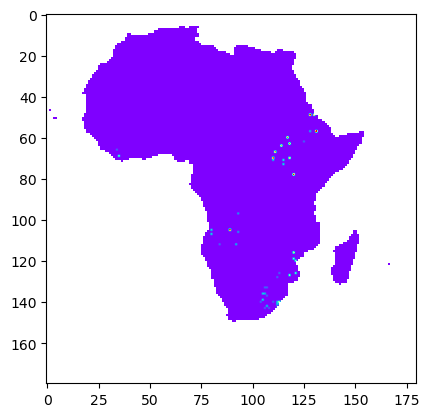

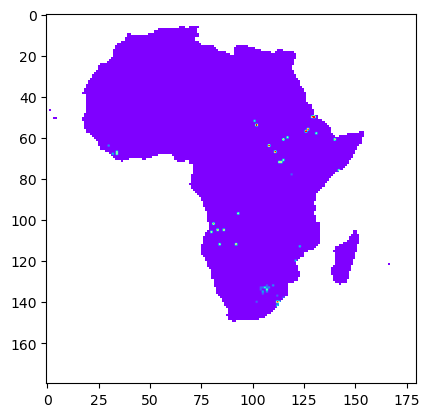

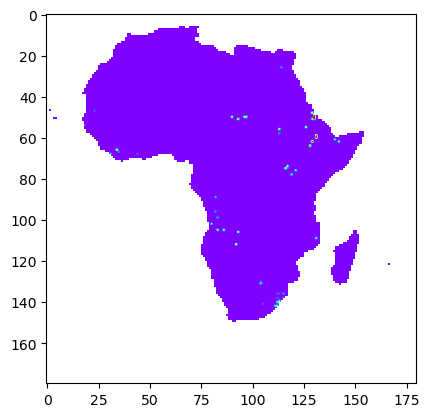

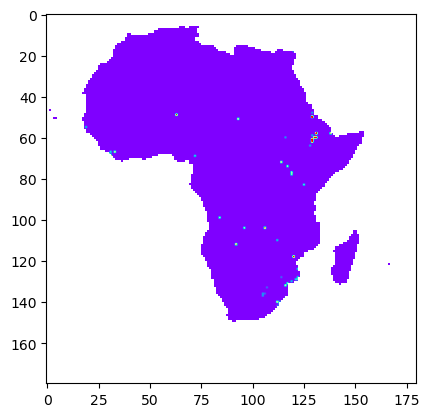

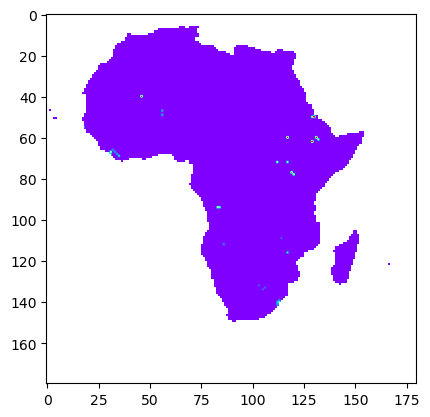

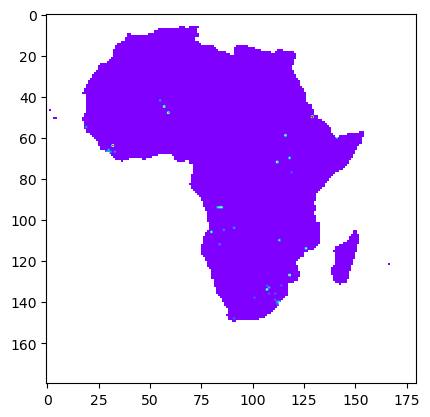

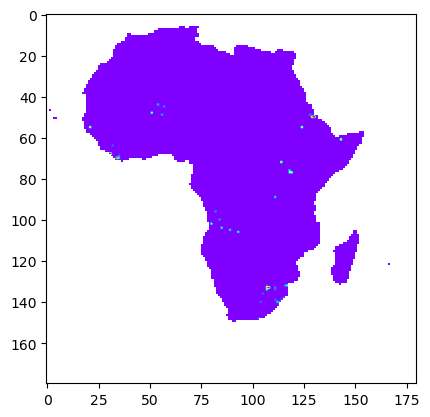

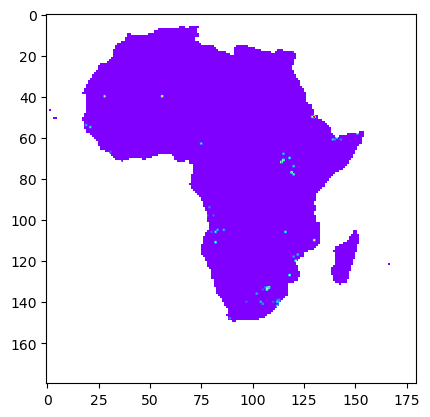

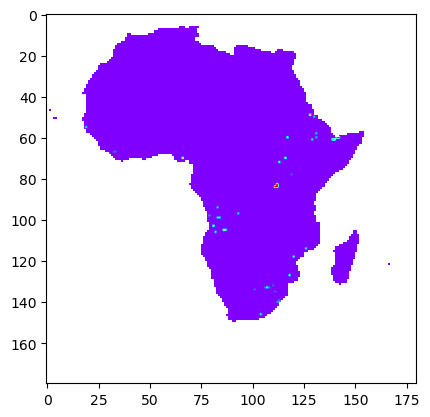

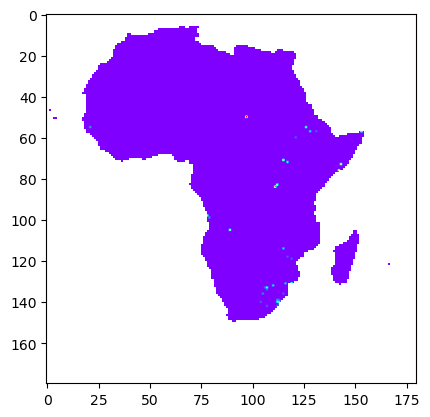

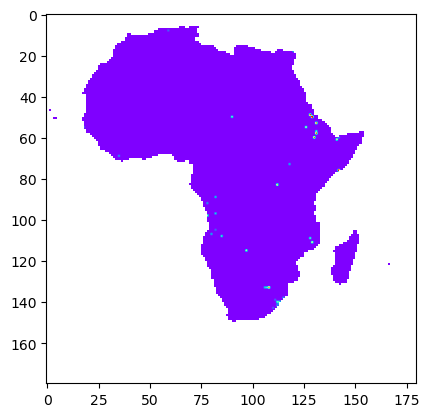

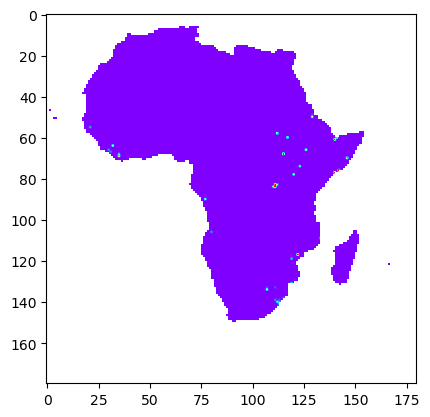

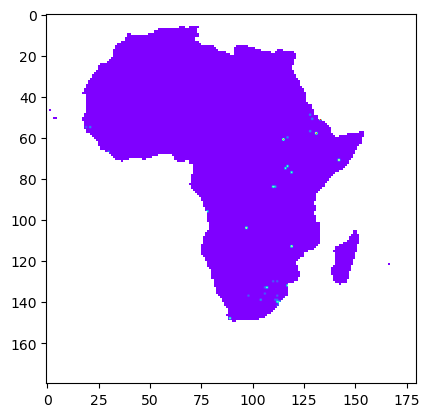

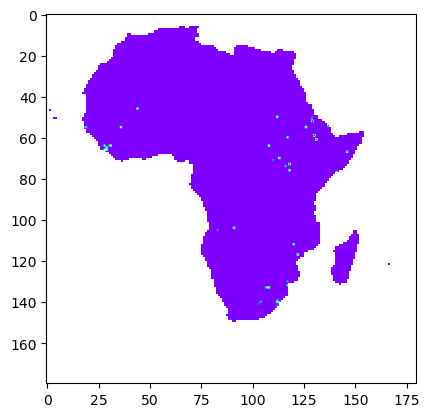

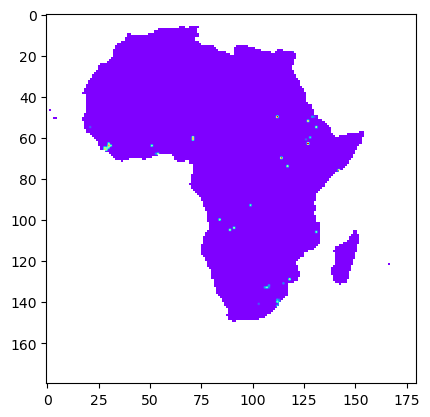

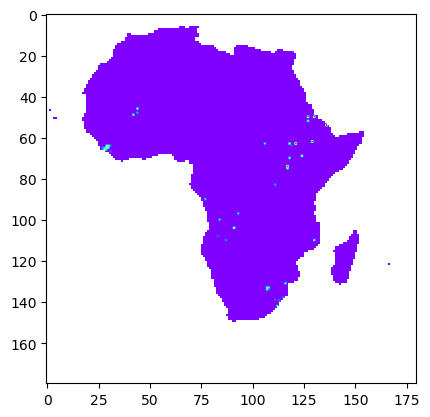

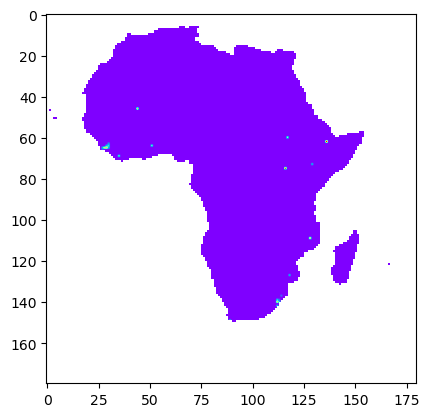

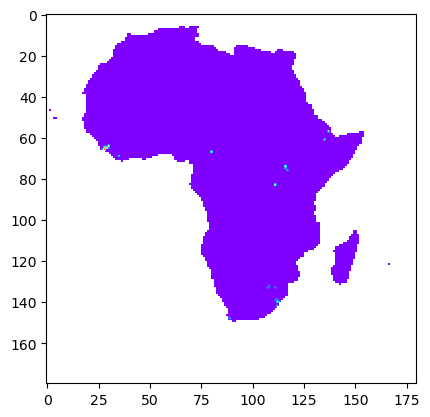

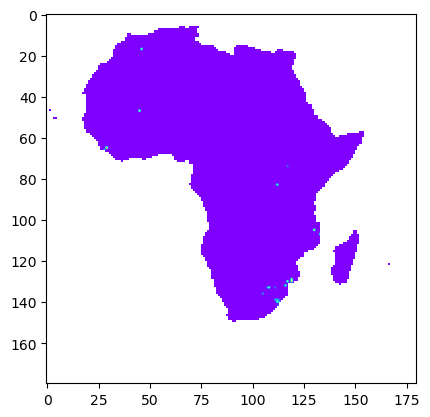

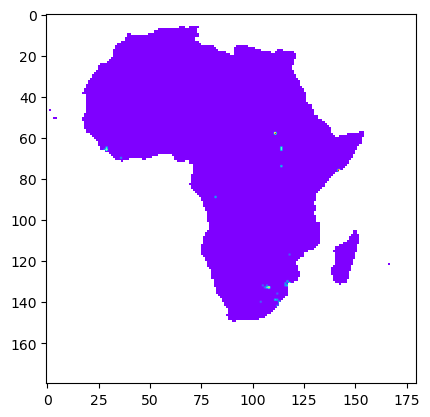

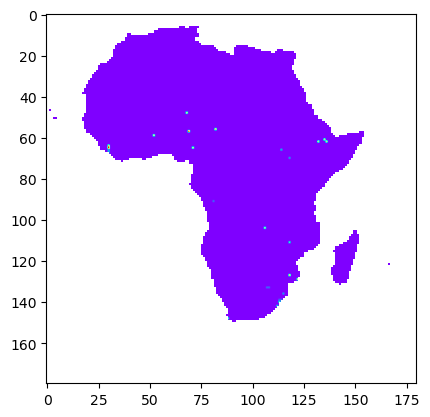

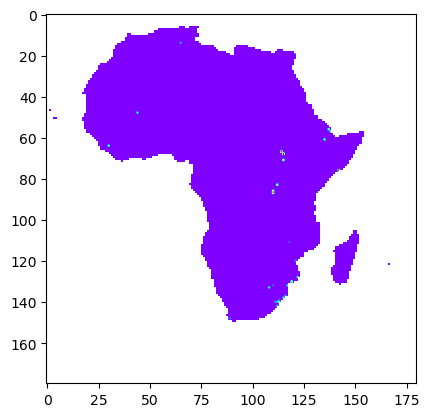

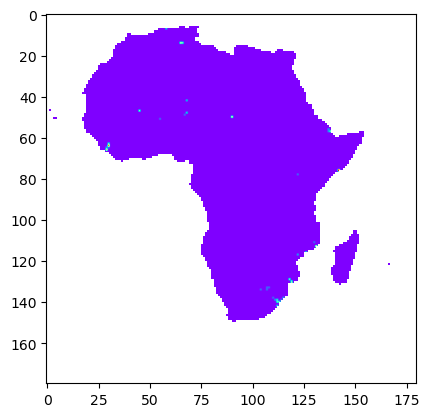

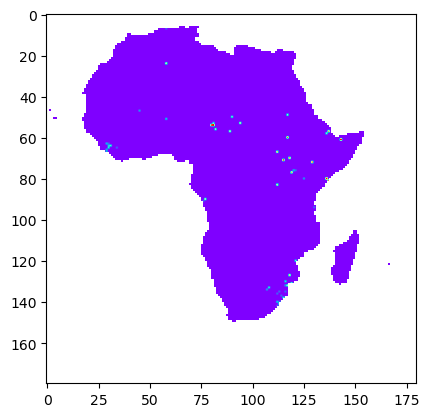

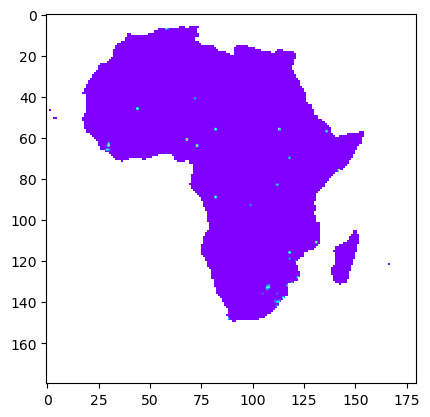

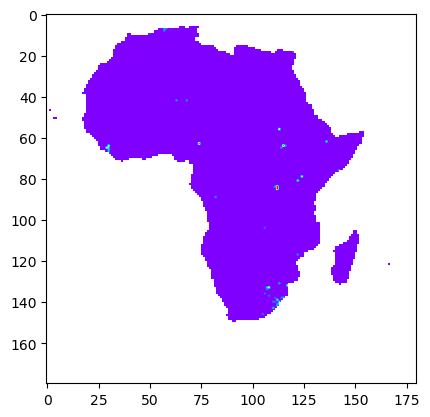

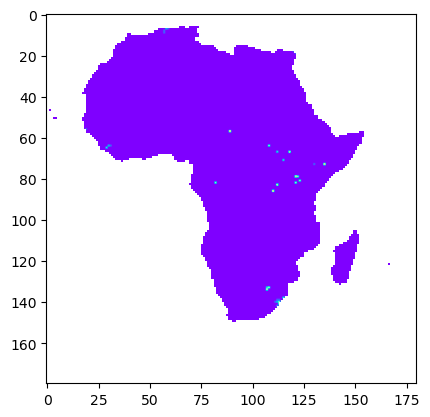

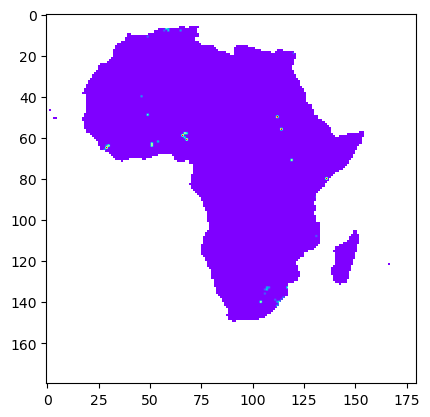

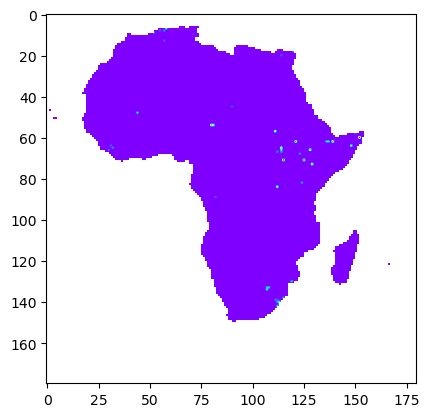

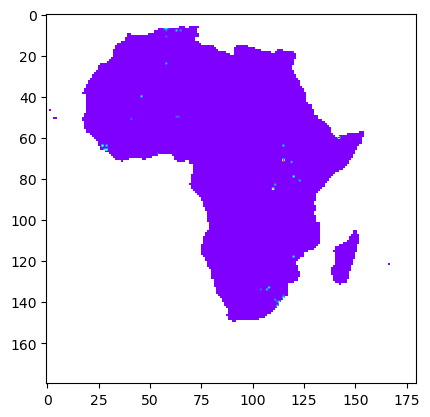

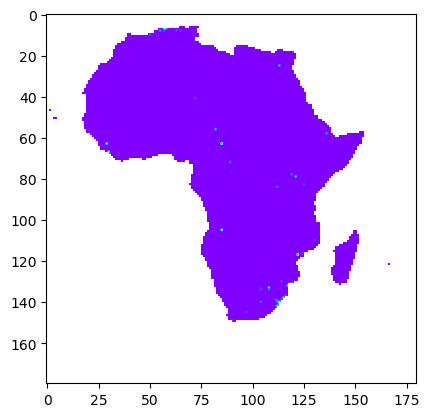

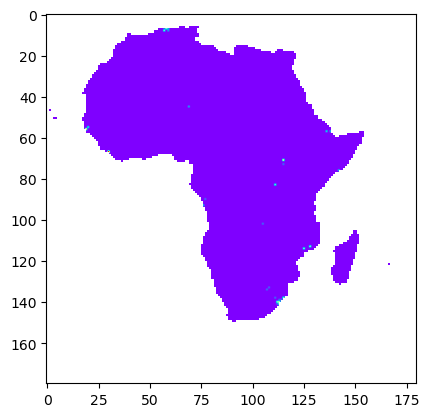

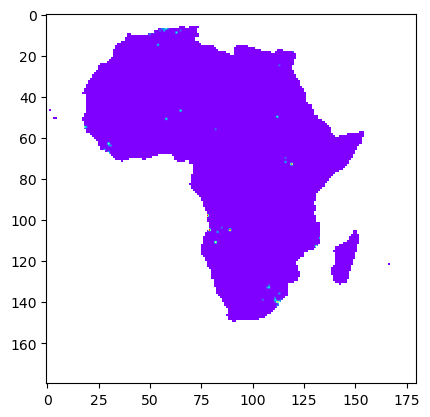

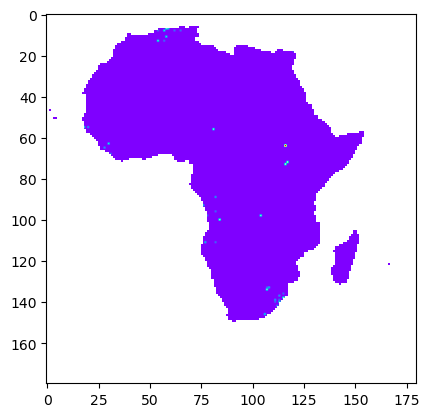

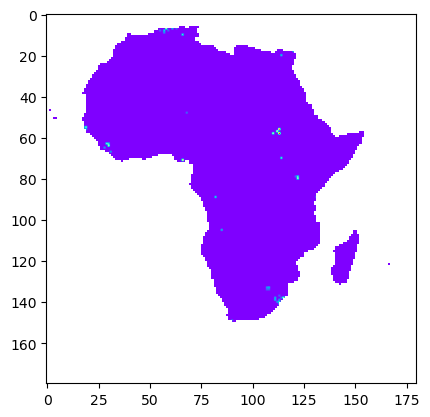

In [23]:
for i in range(views_vol.shape[0]):
    data = np.ma.masked_where((views_vol[i,:,:,10] == 0), views_vol[i,:,:,7])

    plt.imshow(data, cmap = 'rainbow', vmin=views_vol[-1,:,:,7].min() , vmax=views_vol[-1,:,:,7].max())
    plt.show()

In [24]:
ucdp['year'].unique().shape

(4,)

In [25]:
df_views['year'].unique().shape

(30,)

In [26]:
df_views[(df_views['year'] == 2017) & (df_views['month'] == 12)]['month_id'].unique()

array([456])

In [27]:
df_views['month_id'].max()

468